# Return Period for La ReUnion Best Track Data

This notebook reviews the return period using La ReUnion Best Track data

A buffer around each forecasted point is added using the radius of max wind in the data available in nautical miles.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime
from shapely.geometry import Point
import numpy as np
from src import constants

In [3]:
adm0_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)
adm1_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm1_BNGRC_OCHA_20181031.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_adm1_sel = gdf_adm1[gdf_adm1["ADM1_EN"].isin(constants.ADMS)]

<Axes: >

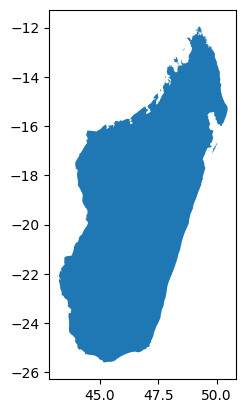

In [4]:
gdf_adm0.plot()

In [5]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    Path(constants.AA_DATA_DIR)
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

Small issue with some Lat values not being negative

In [6]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)
cyclone_tracks.loc[:, "Season"] = cyclone_tracks.apply(
    lambda x: (
        f"{x['Year'] - 1}-{x['Year']}"
        if x["Month"] <= 6
        else f"{x['Year']}-{x['Year'] + 1}"
    ),
    axis=1,
)
cyclone_tracks_buffer = cyclone_tracks.copy()
cyclone_tracks_buffer["RMW_km"] = cyclone_tracks_buffer["RMW (mn)"] * 1.852

In [7]:
cyclone_tracks_buffer["RMW_km"] = (
    cyclone_tracks_buffer["RMW_km"].fillna(1).replace(0, 1)
)

In [8]:
# Create 'geometry' column in cyclone_tracks GeoDataFrame using Lat/Lon for the points
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)

# Convert cyclone_tracks DataFrame to GeoDataFrame
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)

# Create 'geometry' column in cyclone_tracks_buffer GeoDataFrame
cyclone_tracks_buffer["geometry"] = cyclone_tracks_buffer.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)

# Convert cyclone_tracks_buffer DataFrame to GeoDataFrame
cyclone_tracks_gdf_buffer = gpd.GeoDataFrame(
    cyclone_tracks_buffer, geometry="geometry", crs="EPSG:4326"
)

# Create buffers for the cyclone tracks using the RMW_km column, converting km to degrees

# Create buffer around gdf_adm0 with the given distance
# Reproject to a CRS that uses meters (e.g., EPSG:3857)
cyclone_tracks_gdf_buffer = cyclone_tracks_gdf_buffer.to_crs(
    epsg=constants.mdg_epsg
)

# Apply the buffer of 100 km (100,000 meters)
cyclone_tracks_gdf_buffer["geometry"] = (
    cyclone_tracks_gdf_buffer.geometry.buffer(
        cyclone_tracks_gdf_buffer["RMW_km"] * 1000
    )
)

# Reproject back to the original CRS
cyclone_tracks_gdf_buffer = cyclone_tracks_gdf_buffer.to_crs(
    cyclone_tracks_gdf.crs
)

Country-Wide

In [9]:
buffer = True
if buffer:
    # Create buffer around gdf_adm0 with the given distance
    # Reproject to a CRS that uses meters (e.g., EPSG:3857)
    gdf_adm0_buffer = gdf_adm0.to_crs(epsg=constants.mdg_epsg)

    # Apply the buffer of 100 km (100,000 meters)
    gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
        constants.buffer * 1000
    )  # 100 km = 100,000 meters

    # Reproject back to the original CRS
    gdf_adm0_buffer = gdf_adm0_buffer.to_crs(gdf_adm0.crs)
else:
    gdf_adm0_buffer = gdf_adm0.copy()

In [10]:
cyclone_tracks_adm0 = gpd.sjoin(
    cyclone_tracks_gdf, gdf_adm0, how="inner", predicate="intersects"
)

cyclone_tracks_adm0_buffer_wradius = gpd.sjoin(
    cyclone_tracks_gdf_buffer,
    gdf_adm0_buffer,
    how="inner",
    predicate="intersects",
)
cyclone_tracks_adm0_buffer = gpd.sjoin(
    cyclone_tracks_gdf, gdf_adm0_buffer, how="inner", predicate="intersects"
)

cyclone_tracks_adm0_wradius = gpd.sjoin(
    cyclone_tracks_gdf_buffer,
    gdf_adm0,
    how="inner",
    predicate="intersects",
)

<Axes: >

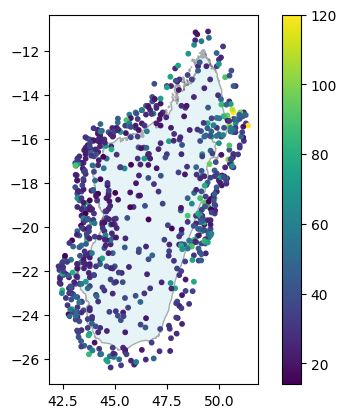

In [11]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
cyclone_tracks_adm0_buffer.plot(
    ax=ax, column="Max wind (kt)", markersize=10, legend=True
)

<Axes: >

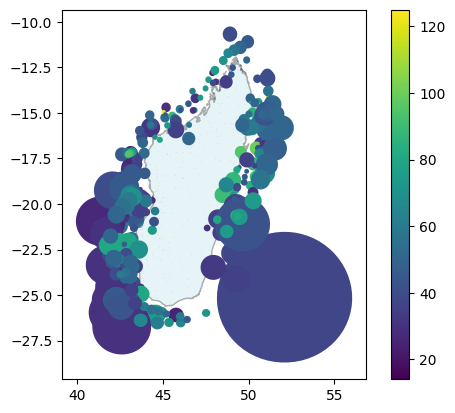

In [12]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
cyclone_tracks_adm0_buffer_wradius.plot(
    ax=ax, column="Max wind (kt)", markersize=10, legend=True
)

Selected Regions

In [13]:
buffer = True
if buffer:
    # Create buffer around gdf_adm0 with the given distance
    # Reproject to a CRS that uses meters (e.g., EPSG:29702)
    gdf_adm1_sel_buffer = gdf_adm1_sel.to_crs(epsg=constants.mdg_epsg)

    # Apply the buffer of 100 km (100,000 meters)
    gdf_adm1_sel_buffer["geometry"] = gdf_adm1_sel_buffer.geometry.buffer(
        constants.buffer * 1000
    )  # 100 km = 100,000 meters

    # Reproject back to the original CRS
    gdf_adm1_sel_buffer = gdf_adm1_sel_buffer.to_crs(gdf_adm1.crs)
else:
    gdf_adm1_sel_buffer = gdf_adm1_sel.copy()

cyclone_tracks_sel_adm1 = gpd.sjoin(
    cyclone_tracks_gdf,
    gdf_adm1_sel,
    how="inner",
    predicate="intersects",
)
cyclone_tracks_sel_adm1_wradius = gpd.sjoin(
    cyclone_tracks_gdf_buffer,
    gdf_adm1_sel,
    how="inner",
    predicate="intersects",
)
cyclone_tracks_sel_adm1_buffer = gpd.sjoin(
    cyclone_tracks_gdf,
    gdf_adm1_sel_buffer,
    how="inner",
    predicate="intersects",
)
cyclone_tracks_sel_adm1_buffer_wradius = gpd.sjoin(
    cyclone_tracks_gdf_buffer,
    gdf_adm1_sel_buffer,
    how="inner",
    predicate="intersects",
)

<Axes: >

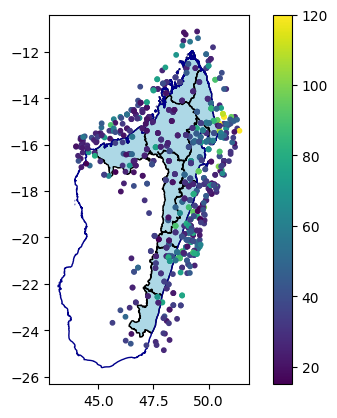

In [14]:
ax = gdf_adm1_sel.plot(color="lightblue", edgecolor="black")
gdf_adm0.plot(ax=ax, color="none", edgecolor="darkblue", linewidth=1)
cyclone_tracks_sel_adm1_buffer.plot(
    ax=ax, column="Max wind (kt)", markersize=10, legend=True
)

<Axes: >

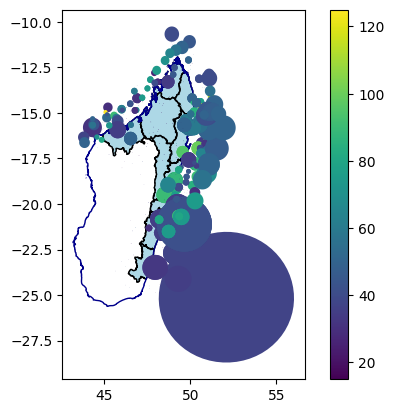

In [15]:
ax = gdf_adm1_sel.plot(color="lightblue", edgecolor="black")
gdf_adm0.plot(ax=ax, color="none", edgecolor="darkblue", linewidth=1)
cyclone_tracks_sel_adm1_buffer_wradius.plot(
    ax=ax, column="Max wind (kt)", markersize=10, legend=True
)

In [16]:
cyclone_tracks_sel_adm1["Name"].unique()

array(['CALIDERA', 'DOAZA', 'FILAO', 'HELY', 'ALIBERA', 'G19091', 'BRYNA',
       'ELIZABETHA', 'HUTELLE', 'IONIA', 'DAISY', 'GERALDA', 'LITANNE',
       'CHRISTELLE', 'BONITA', 'FABRIOLA', 'JOSIE', 'ASTRIDE', 'ELINE',
       'GLORIA', 'HUDAH', 'DERA', 'GUILLAUME', 'KESINY', 'FARI', 'CELA',
       'ELITA', 'GAFILO', '720052006', 'BOLOETSE', 'BONDO', 'CLOVIS',
       'INDLALA', 'JAYA', 'FAME', 'IVAN', 'JOKWE', 'JADE', 'FAMI',
       'HUBERT', 'BINGIZA', 'GIOVANNA', 'IRINA', '820132014', 'HELLEN',
       'CHEDZA', '1120142015', 'ENAWO', 'AVA', 'ELIAKIM', 'DIANE',
       'FRANCISCO', 'CHALANE', 'ELOISE', 'IMAN', 'ANA', 'BATSIRAI',
       'DUMAKO', 'EMNATI', 'GOMBE', 'CHENESO', 'FREDDY'], dtype=object)

In [17]:
cyclone_tracks_sel_adm1.columns

Index(['Name', 'Depr Num', 'Day', 'Month', 'Year', 'UTC', 'Lat', 'Lon',
       'Accu (mn)', 'Max wind (kt)', 'Gust (kt)', 'RMW (mn)', 'MSLP (hPa)',
       'FT', 'Ci', '28kt_NE_mn', '28kt_SE_mn', '28kt_SW_mn', '28kt_NW_mn',
       '34kt_NE_mn', '34kt_SE_mn', '34kt_SW_mn', '34kt_NW_mn', '48kt_NE_mn',
       '48kt_SE_mn', '48kt_SW_mn', '48kt_NW_mn', '64kt_NE_mn', '64kt_SE_mn',
       '64kt_SW_mn', '64kt_NW_mn', 'Season', 'geometry', 'index_right',
       'ADM0_PCODE', 'ADM0_EN', 'ADM1_PCODE', 'ADM1_EN', 'ADM1_TYPE',
       'PROV_CODE', 'OLD_PROVIN', 'PROV_TYPE', 'SOURCE'],
      dtype='object')

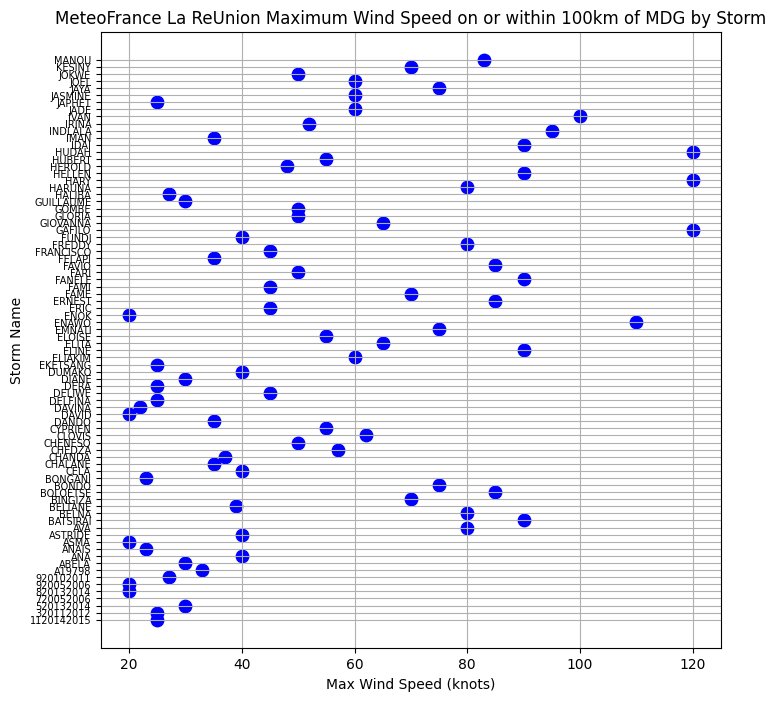

In [18]:
max_values = (
    cyclone_tracks_adm0_buffer[cyclone_tracks_adm0_buffer["Year"] >= 1998]
    .groupby("Name")["Max wind (kt)"]
    .max()
    .reset_index()
)

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(8, 8))
plt.scatter(
    max_values["Max wind (kt)"],
    max_values["Name"],
    color="blue",
    s=80,
    label="Max Wind Speed",
)
plt.yticks(fontsize=7)  # Adjust the fontsize value as needed
# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed (knots)")
plt.title(
    "MeteoFrance La ReUnion Maximum Wind Speed on or within 100km of MDG by Storm"
)
plt.grid(True)
plt.show()

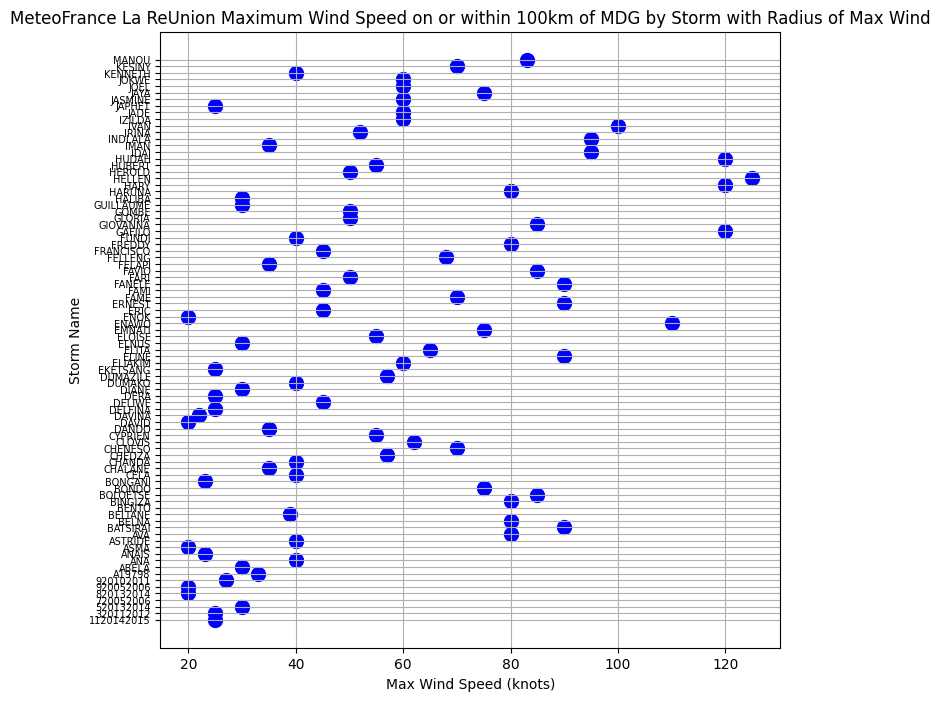

In [19]:
max_values = (
    cyclone_tracks_adm0_buffer_wradius[
        cyclone_tracks_adm0_buffer_wradius["Year"] >= 1998
    ]
    .groupby("Name")["Max wind (kt)"]
    .max()
    .reset_index()
)

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(8, 8))
plt.scatter(
    max_values["Max wind (kt)"],
    max_values["Name"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)
plt.yticks(fontsize=7)  # Adjust the fontsize value as needed
# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed (knots)")
plt.title(
    "MeteoFrance La ReUnion Maximum Wind Speed on or within 100km of MDG by Storm with Radius of Max Wind"
)
plt.grid(True)
plt.show()

Function to compute the return period from Best Track Data

In [20]:
def calculate_storm_return_period_la_reunion(
    df, wind_speed_kmh_min, wind_speed_kmh_max, start_year
):

    # Convert the given speed from km/h to knots
    # Convert the given speed from km/h to knots
    min_speed_knots = wind_speed_kmh_min * constants.kmh_to_knots
    max_speed_knots = wind_speed_kmh_max * constants.kmh_to_knots

    # Ensure UTC is formatted as a two-digit hour
    df["UTC"] = df["UTC"].apply(lambda x: f"{int(x):02}")
    # Create a datetime column from separate date and time columns
    df["ISO_TIME"] = pd.to_datetime(
        df[["Year", "Month", "Day", "UTC"]].astype(str).agg(" ".join, axis=1)
    )

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].dt.year

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year)
        & (df["Max wind (kt)"] >= min_speed_knots)
        & (df["Max wind (kt)"] < max_speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["Season"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2023 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh_min} km/h is 1-in-{round(combined_return_period, 1)} years."
    )

### Country-Wide

#### Since 1985

Scenario 2 with an upper bound

In [34]:
# Scenario 2
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_adm0_buffer_wradius,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=2000,
)

The combined return period of storms over 118 km/h is 1-in-1.3 years.


In [22]:
# Scenario 2
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_adm0_buffer,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=1985,
)

The combined return period of storms over 118 km/h is 1-in-1.5 years.


Scenario 2 with a high upper bound (Scenario 2 and 3)

In [ ]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_adm0_buffer_wradius,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,
    start_year=1985,
)

The combined return period of storms over 118 km/h is 1-in-1.3 years.


In [24]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_adm0_buffer,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,
    start_year=1985,
)

The combined return period of storms over 118 km/h is 1-in-1.4 years.


Scenario 3 

In [ ]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_adm0_buffer_wradius,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,
    start_year=1985,
)

The combined return period of storms over 166 km/h is 1-in-2.2 years.


In [26]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_adm0_buffer,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,
    start_year=1985,
)

The combined return period of storms over 166 km/h is 1-in-3.2 years.


### Selected Regions

#### Since 1985

Scenario 2 with an upper bound

In [27]:
# Scenario 2
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm1_buffer_wradius,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=1985,
)

The combined return period of storms over 118 km/h is 1-in-1.9 years.


In [28]:
# Scenario 2
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm1_buffer,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=1985,
)

The combined return period of storms over 118 km/h is 1-in-1.9 years.


Scenario 2 with a high upper bound (Scenario 2 and 3)

In [29]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm1_buffer_wradius,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,
    start_year=1985,
)

The combined return period of storms over 118 km/h is 1-in-1.8 years.


In [30]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm1_buffer,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,
    start_year=1985,
)

The combined return period of storms over 118 km/h is 1-in-1.9 years.


Scenario 3 

In [31]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm1_buffer_wradius,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,
    start_year=1985,
)

The combined return period of storms over 166 km/h is 1-in-3.9 years.


In [32]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm1_buffer,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,
    start_year=1985,
)

The combined return period of storms over 166 km/h is 1-in-3.9 years.


In [33]:
def scenario_2_point_5(df, gdf_adm, start_year=1985):
    storm_data = []

    # Define thresholds for scenarios
    min_speed_knots = 118 * constants.kmh_to_knots
    max_speed_knots = 166 * constants.kmh_to_knots
    min_speed_knots_buffer = max_speed_knots  # 166 km/h in Scenario 3
    # Ensure UTC is formatted as a two-digit hour
    df["UTC"] = df["UTC"].apply(lambda x: f"{int(x):02}")
    # Create a datetime column from separate date and time columns
    df["ISO_TIME"] = pd.to_datetime(
        df[["Year", "Month", "Day", "UTC"]].astype(str).agg(" ".join, axis=1)
    )

    # Scenario 2: Filter storms with 118-166 km/h wind speeds
    df_filtered_nobuffer = df.loc[
        (df["Year"] >= start_year)
        & (df["Max wind (kt)"] >= min_speed_knots)
        & (df["Max wind (kt)"] < max_speed_knots)
    ]

    # Perform spatial join without buffer
    gdf_points_nobuffer = gpd.sjoin(
        df_filtered_nobuffer,
        gdf_adm,
        how="inner",
        predicate="intersects",
        rsuffix="admin",
    )

    # Collect storm data for Scenario 2
    for storm in gdf_points_nobuffer["Name"].unique():
        storm_entries = gdf_points_nobuffer[
            gdf_points_nobuffer["Name"] == storm
        ][["Year", "Season"]].drop_duplicates()
        for _, row in storm_entries.iterrows():
            storm_data.append(
                {
                    "storm_name": storm,
                    "year": row["Year"],
                    "season": row[
                        "Season"
                    ],  # Use season directly from gdf_points_nobuffer
                    "type": "Scenario 2 with no buffer",
                }
            )

    # Scenario 3: Filter storms with wind speeds >= 166 km/h with 100 km buffer
    gdf_adm_buffer = gdf_adm.to_crs(epsg=constants.mdg_epsg)
    gdf_adm_buffer["geometry"] = gdf_adm_buffer.geometry.buffer(
        constants.buffer * 1000
    )  # 100 km buffer
    gdf_adm_buffer = gdf_adm_buffer.to_crs(gdf_adm.crs)

    # Filter DataFrame for storms with 166 km/h or higher wind speeds
    df_filtered_buffer = df.loc[
        (df["Year"] >= start_year)
        & (df["Max wind (kt)"] >= min_speed_knots_buffer)
    ]
    gdf_points_buffer = gpd.sjoin(
        df_filtered_buffer,
        gdf_adm_buffer,
        how="inner",
        predicate="within",
        rsuffix="admin",
    )

    # Collect storm data for Scenario 3
    for storm in gdf_points_buffer["Name"].unique():
        storm_entries = gdf_points_buffer[gdf_points_buffer["Name"] == storm][
            ["Year", "Season"]
        ].drop_duplicates()
        for _, row in storm_entries.iterrows():
            storm_data.append(
                {
                    "storm_name": storm,
                    "year": row["Year"],
                    "season": row[
                        "Season"
                    ],  # Use season directly from gdf_points_buffer
                    "type": "Scenario 3 with 100km buffer",
                }
            )

    # Convert storm data to DataFrame, remove duplicates, and calculate return period
    storm_data_df = pd.DataFrame(storm_data).drop_duplicates(
        subset=["storm_name", "season"]
    )
    yr_len = 2023 - start_year + 1
    combined_return_period = yr_len / storm_data_df["season"].nunique()

    print(
        f"The combined return period of storms is 1-in-{round(combined_return_period, 1)} years."
    )
    return storm_data_df

In [ ]:
scenario_2_point_5(df=cyclone_tracks_gdf, gdf_adm=gdf_adm0, start_year=1985)

The combined return period of storms is 1-in-1.9 years.


,storm_name,year,season,type
0,CALIDERA,1988,1987-1988,Scenario 2 with no buffer
1,CALASANJY,1989,1988-1989,Scenario 2 with no buffer
2,LITANNE,1994,1993-1994,Scenario 2 with no buffer
3,GAFILO,2004,2003-2004,Scenario 2 with no buffer
4,INDLALA,2007,2006-2007,Scenario 2 with no buffer
5,FAME,2008,2007-2008,Scenario 2 with no buffer
6,FANELE,2009,2008-2009,Scenario 2 with no buffer
7,BINGIZA,2011,2010-2011,Scenario 2 with no buffer
8,GIOVANNA,2012,2011-2012,Scenario 2 with no buffer
9,HARUNA,2013,2012-2013,Scenario 2 with no buffer


In [64]:
scenario_2_point_5(
    df=cyclone_tracks_gdf_buffer, gdf_adm=gdf_adm0, start_year=1985
)

The combined return period of storms is 1-in-1.8 years.


,storm_name,year,season,type
0,CALIDERA,1988,1987-1988,Scenario 2 with no buffer
1,CALASANJY,1989,1988-1989,Scenario 2 with no buffer
2,LITANNE,1994,1993-1994,Scenario 2 with no buffer
3,EDWIGE,1996,1995-1996,Scenario 2 with no buffer
4,MANOU,2003,2002-2003,Scenario 2 with no buffer
5,GAFILO,2004,2003-2004,Scenario 2 with no buffer
6,ERNEST,2005,2004-2005,Scenario 2 with no buffer
7,BOLOETSE,2006,2005-2006,Scenario 2 with no buffer
8,INDLALA,2007,2006-2007,Scenario 2 with no buffer
9,FAME,2008,2007-2008,Scenario 2 with no buffer


In [65]:
scenario_2_point_5(
    df=cyclone_tracks_gdf, gdf_adm=gdf_adm1_sel, start_year=1985
)

The combined return period of storms is 1-in-2.6 years.


,storm_name,year,season,type
0,CALIDERA,1988,1987-1988,Scenario 2 with no buffer
1,LITANNE,1994,1993-1994,Scenario 2 with no buffer
2,GAFILO,2004,2003-2004,Scenario 2 with no buffer
3,INDLALA,2007,2006-2007,Scenario 2 with no buffer
4,BINGIZA,2011,2010-2011,Scenario 2 with no buffer
5,GIOVANNA,2012,2011-2012,Scenario 2 with no buffer
6,ENAWO,2017,2016-2017,Scenario 2 with no buffer
7,AVA,2018,2017-2018,Scenario 2 with no buffer
8,BATSIRAI,2022,2021-2022,Scenario 2 with no buffer
9,EMNATI,2022,2021-2022,Scenario 2 with no buffer


In [66]:
scenario_2_point_5(
    df=cyclone_tracks_gdf_buffer, gdf_adm=gdf_adm1_sel, start_year=1985
)

The combined return period of storms is 1-in-2.3 years.


,storm_name,year,season,type
0,CALIDERA,1988,1987-1988,Scenario 2 with no buffer
1,LITANNE,1994,1993-1994,Scenario 2 with no buffer
2,EDWIGE,1996,1995-1996,Scenario 2 with no buffer
3,MANOU,2003,2002-2003,Scenario 2 with no buffer
4,GAFILO,2004,2003-2004,Scenario 2 with no buffer
5,INDLALA,2007,2006-2007,Scenario 2 with no buffer
6,BINGIZA,2011,2010-2011,Scenario 2 with no buffer
7,GIOVANNA,2012,2011-2012,Scenario 2 with no buffer
8,ENAWO,2017,2016-2017,Scenario 2 with no buffer
9,AVA,2018,2017-2018,Scenario 2 with no buffer
